In [30]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense, concatenate, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, Conv2DTranspose,BatchNormalization,Dropout, Flatten
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import cv2
import os
import glob
from PIL import Image, ImageFilter
from tensorflow import keras


In [ ]:
# read images to np.array
filelist = glob.glob('/moon-pictures/*.jpg')

x_train = np.array([np.array(Image.open(fname)).astype(np.float32)/255 for fname in filelist])

print(x_train.shape)

filelist = glob.glob('/landscape Images/color/*.jpg')
x_landscape = np.array([np.array(Image.open(fname)).astype(np.float32)/255 for fname in filelist])
print(x_landscape.shape)

# filter to blur images
blurry  =np.array([np.array(Image.open(fname).filter(ImageFilter.GaussianBlur(radius = 2))).astype(np.float32)/255 for fname in filelist])
print(x_landscape.shape)

filelist = glob.glob('/Phases of moon dataset/test/Full Moon/*.jpg')
x_test = np.array([np.array(Image.open(fname)).astype(np.float32) for fname in filelist])
print(x_test.shape)



Resize images and fill with zeros if necessary. Sizes should be dividable by 4.

In [105]:
max_shape = (160,160,3) #tuple(max(image.shape[x] for image in x_train) for x in range(3)) #
image_batch = np.zeros((x_train.size,) + max_shape, dtype='float32')
for image_index, image in enumerate(x_train):
        image_batch[image_index, :min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3] = image[:min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3]
print(image_batch.shape)

(25, 160, 160, 3)


In [106]:
max_shape = (160,160,3) #tuple(max(image.shape[x] for image in x_train) for x in range(3)) #
test_batch = np.zeros((x_test.size,) + max_shape, dtype='float32')
for image_index, image in enumerate(x_test):
        test_batch[image_index, :min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3] = image[:min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3]
print(test_batch.shape)

(15, 160, 160, 3)


In [7]:
max_shape = (160,160,3) #tuple(max(image.shape[x] for image in x_train) for x in range(3)) #
image_landscape = np.zeros((x_landscape.shape[0],) + max_shape, dtype='float32')
for image_index, image in enumerate(x_landscape):
        image_landscape[image_index, :min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3] = image[:min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3]
print(image_landscape.shape)

(1997, 160, 160, 3)


In [14]:
max_shape = (160,160,3) #tuple(max(image.shape[x] for image in x_train) for x in range(3)) #
image_blurry = np.zeros((blurry.shape[0],) + max_shape, dtype='float32')
for image_index, image in enumerate(blurry):
        image_blurry[image_index, :min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3] = image[:min(image.shape[0],max_shape[0])-1,:min(image.shape[1],max_shape[1])-1,:3]
print(image_landscape.shape)

(1997, 160, 160, 3)


image_test_batch = np.zeros((x_train.size,) + max_shape, dtype='float32')
for image_index, image in enumerate(x_test):
        image_test_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

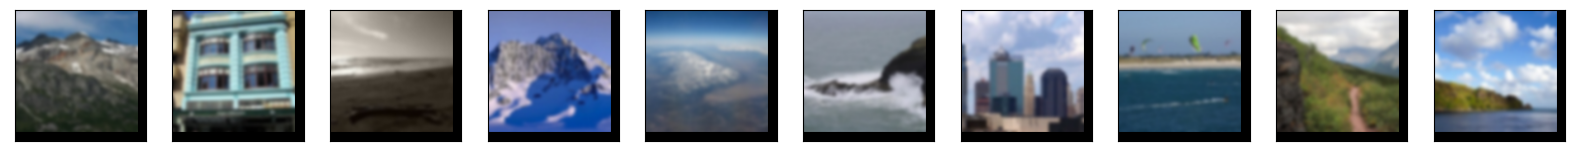

In [17]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
%matplotlib inline 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.uint8(image_blurry[i]*255))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [33]:
# The encoding process
input_img = Input(shape=(160, 160, 3))  

x = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Dropout(0.2)(x)

x = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Dropout(0.2)(x)

x = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(x)

encoded = Conv2D(filters = 512, kernel_size =(3, 3), activation='relu', padding='same')(x)


In [34]:
# The decoding process
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
x = concatenate([x,input_img])
decoded = Conv2D(3, (3, 3), padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [35]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 160, 160, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 80, 80, 128)  0          ['conv2d_23[0][0]']              
                                                                                            

In [40]:


# Restore the weights
#autoencoder.load_weights('./')

In [41]:
autoencoder.fit(image_blurry, image_landscape,
                epochs=5)


Epoch 1/5
63/63 [==============================] - 195s 3s/step - loss: 0.0124
Epoch 2/5
63/63 [==============================] - 231s 4s/step - loss: 0.0114
Epoch 3/5
63/63 [==============================] - 242s 4s/step - loss: 0.0109
Epoch 4/5
63/63 [==============================] - 231s 4s/step - loss: 0.0106
Epoch 5/5
63/63 [==============================] - 240s 4s/step - loss: 0.0105


In [42]:
autoencoder.save_weights('/blurry_concatenate')

In [43]:
decoded_imgs = autoencoder.predict(image_blurry[:10])



1/1 [==============================] - 0s 348ms/step


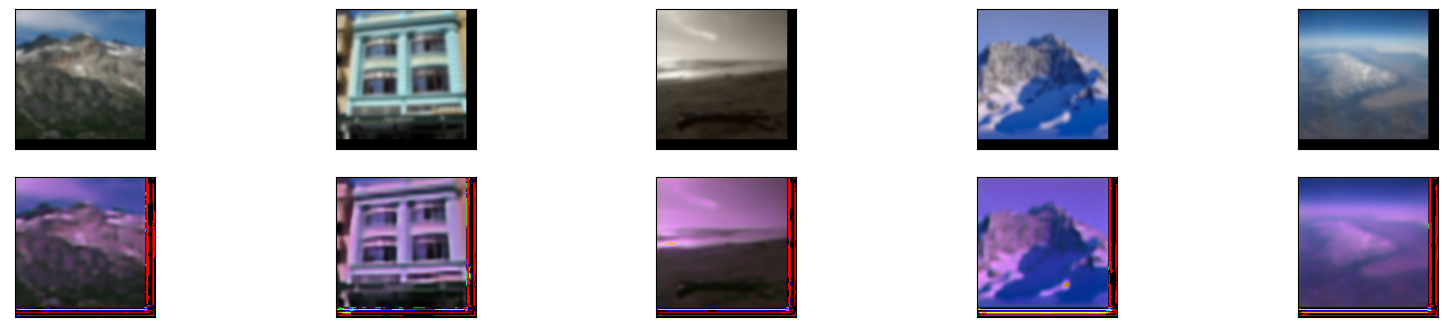

In [44]:
n = 5

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.uint8(image_blurry[i]*255))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(np.uint8(decoded_imgs[i]*255))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
#tf.keras.metrics.mean_squared_error(image_batch,decoded_imgs).shape
np.mean(np.square(image_blurry[0] - decoded_imgs[0]), axis=(0,1))

array([0.00034459, 0.01071856, 0.00146756], dtype=float32)

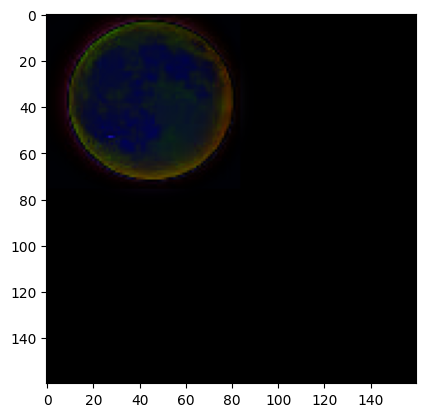

In [71]:
plt.imshow(np.square(image_batch[0] - decoded_imgs[0]))

In [72]:
# The Discriminator
input_img = Input(shape=(160, 160, 3))  

x = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

x = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

x = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(x)

x = Conv2D(filters = 512, kernel_size =(3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

x = Flatten()(x)
#x = Dense(128,activation='relu')(x)
x = Dense(1,activation='sigmoid')(x)

discriminator = Model(input_img, x)

discriminator.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 160, 160, 128)     3584      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 80, 80, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 40, 40, 256)       2951

In [73]:
discriminator_set = np.concatenate((image_batch,decoded_imgs))
#discriminator_set = np.concatenate((image_batch,image_landscape))
labels = np.concatenate((np.zeros(image_batch.shape[0]),np.ones(image_landscape.shape[0])))

In [74]:
discriminator.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])


In [75]:
discriminator.fit(discriminator_set,labels, epochs=10,shuffle=True,)

Epoch 1/10


2022-09-25 16:47:17.332946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 430ms/step - loss: 1.5469 - acc: 0.5800
Epoch 2/10
2/2 [==============================] - 1s 415ms/step - loss: 1.2350 - acc: 0.5400
Epoch 3/10
2/2 [==============================] - 1s 414ms/step - loss: 0.5099 - acc: 0.6800
Epoch 4/10
2/2 [==============================] - 1s 409ms/step - loss: 0.2024 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 409ms/step - loss: 0.0817 - acc: 0.9800
Epoch 6/10
2/2 [==============================] - 1s 408ms/step - loss: 0.0090 - acc: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 400ms/step - loss: 0.0131 - acc: 1.0000
Epoch 8/10
2/2 [==============================] - 1s 405ms/step - loss: 2.3819e-04 - acc: 1.0000
Epoch 9/10
2/2 [==============================] - 1s 407ms/step - loss: 7.1458e-06 - acc: 1.0000
Epoch 10/10
2/2 [==============================] - 1s 417ms/step - loss: 9.7503e-07 - acc: 1.0000


In [76]:
predictions = discriminator.predict(discriminator_set)

1/2 [==============>...............] - ETA: 0s

2022-09-25 16:47:35.202774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 208ms/step


In [77]:
predictions

array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.4219704e-36],
       [0.0000000e+00],
       [5.7198620e-35],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0758264e-19],
       [0.0000000e+00],
       [3.1114292e-31],
       [0.0000000e+00],
       [8.3034947e-29],
       [0.0000000e+00],
       [0.0000000e+00],
       [5.9640899e-33],
       [0.0000000e+00],
       [6.6682797e-32],
       [1.3232970e-29],
       [5.2670250e-33],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999917e-01],
       [1.0000000e+00],
       [9.9999881e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.999996